# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [4]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [5]:
## load dataset here
df = pd.read_csv('/content/drive/MyDrive/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [6]:
## parsing data here
images, labels = parse_data(df)


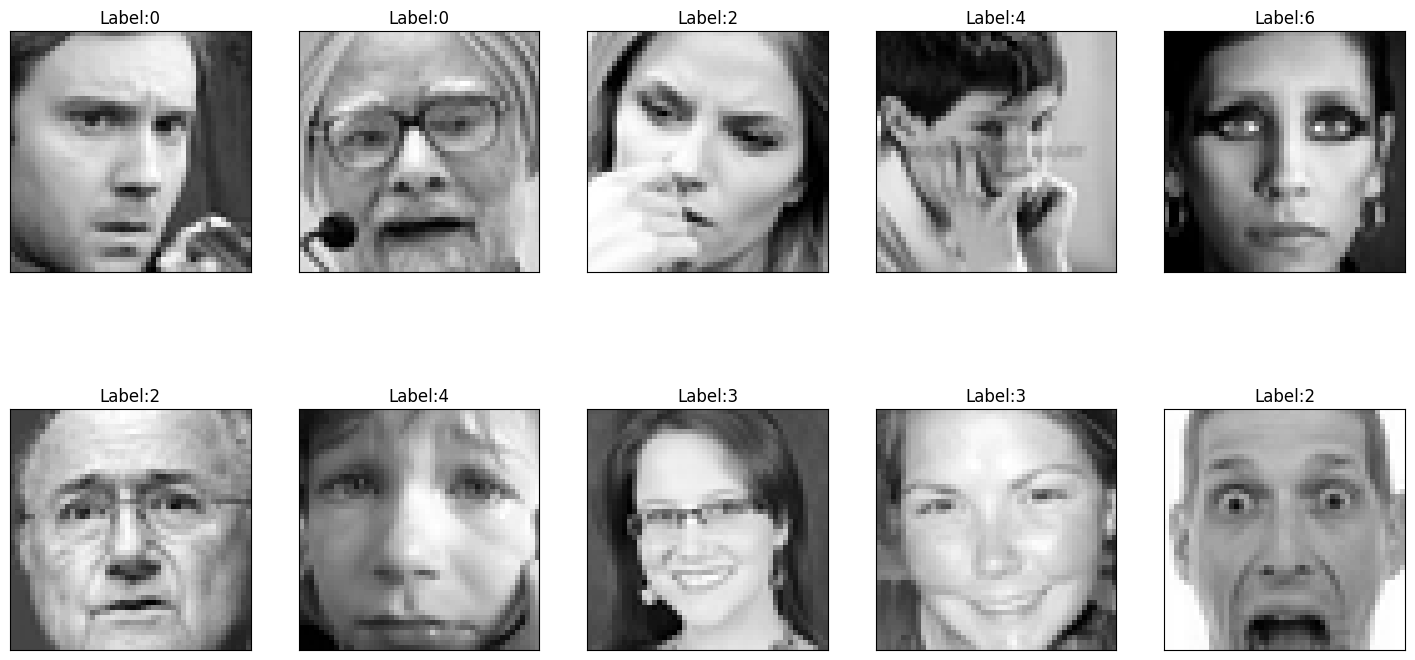

In [7]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [8]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
images_reshaped = images.reshape(images.shape[0], -1) ## modify images' array to the appropriate shape
pca.fit(images_reshaped)

PCA(n_components=2)

In [9]:
images_reshaped.shape

(35887, 2304)

In [10]:
## transform for visualizing here
images_pca=pca.transform(images_reshaped)
images_pca.shape

(35887, 2)

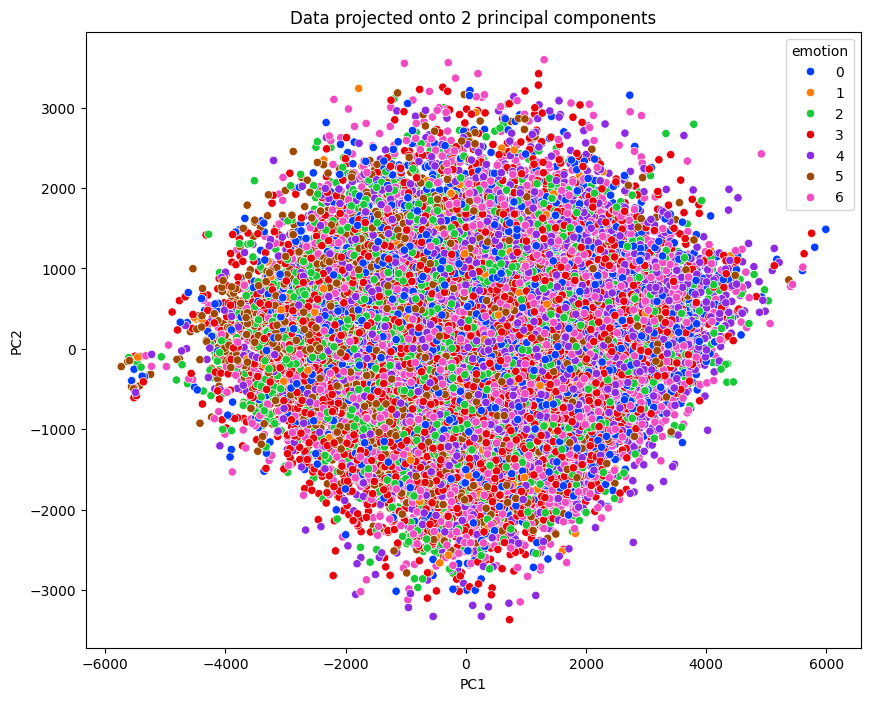

In [11]:
import seaborn as sns
df_pca = pd.DataFrame(data=images_pca, columns=['PC1', 'PC2'])
df_pca['emotion'] = labels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='emotion', palette='bright')
plt.title('Data projected onto 2 principal components')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

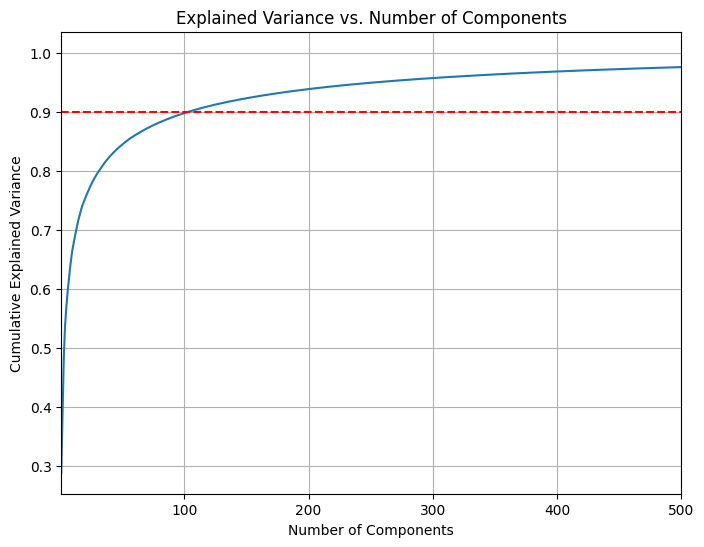

Số lượng principal components ở mức 90%: 104


In [12]:
pca = PCA()
pca.fit(images_reshaped)

explained_variance = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance)

# Chọn số lượng principal components dựa trên ngưỡng phương sai tích lũy
threshold_variance = 0.9 * cumulative_explained_variance[-1]  # 90% của tổng phương sai
n_components = np.argmax(cumulative_explained_variance >= threshold_variance) + 1

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.grid(visible=True)
plt.axhline(y=threshold_variance, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.xlim(1, 500)
plt.show()

print("Số lượng principal components ở mức 90%:", n_components)

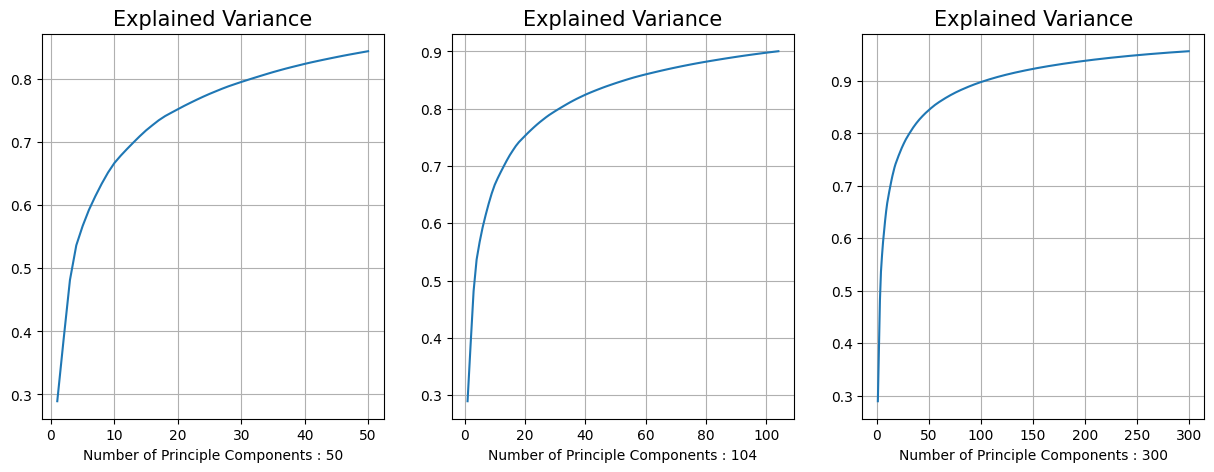

In [13]:
def EV(n):
    pca = PCA(n_components=n, whiten=True)
    pca.fit(images_reshaped)
    #plot
    plt.plot(range(1,n+1), pca.explained_variance_ratio_.cumsum())
    plt.title('Explained Variance',fontsize=15)
    plt.grid(visible=True)
    plt.xlabel('Number of Principle Components : {}'.format(n), fontsize=10)

# use the function above and try use n_component=50,104,and 300
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
EV(50)
plt.subplot(1,3,2)
EV(104)
plt.subplot(1,3,3)
EV(300)

As shown above, if we compress the inputs data into 104 dimensions, we still can obtain the most information from inputs data.

Nếu ta nén dữ liệu input thành 104 chiều, ta vẫn có thể thu được nhiều thông tin nhất từ ​​input.

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [14]:
## splitting data into train/val/test subsets here
from sklearn.model_selection import train_test_split
X = images_reshaped
y = labels

# Train, test, val cho images_reshaped
RANDOM_STATE = 1111
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Chuẩn hóa cho dữ liệu gốc
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#  PCA với n_components = 104
pca = PCA(n_components=104)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)


In [16]:
# import packages for training classifiers
# thêm import của mấy ông vô đây cho gọn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


### Logistic Regressions

In [17]:
#

### Naive Bayes

- Công thức tính phương sai trong mô hình:
$$ \sigma_{cj}^2 = \frac{1}{N_c - 1} \sum_{i=1}^{N} (x_{ij} - \mu_{cj})^2 $$
- Sử dụng siêu tham số var_smoothing để tránh việc phương sai bằng 0 dẫn đến vấn đề khi tính logarit của xác suất:  
$$ \sigma_{cj}^2 = \frac{1}{N_c - 1} \sum_{i=1}^{N} (x_{ij} - \mu_{cj})^2 + var\_smoothing $$


In [18]:
# Định nghĩa mô hình Naive Bayes
model = GaussianNB()
# Thiết lập lưới siêu tham số cho GridSearchCV
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 100) #tạo ra 100 giá trị trong khoảng từ 10^-9 đến 10^0
}

#### 1. Xây dựng mô hình cho dữ liệu gốc images_reshaped

In [19]:
# Khởi tạo GridSearchCV với dữ liệu gốc
grid_search_ogn = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1) # Dữ liệu sẽ được chia thành 5 bằng nhau


In [20]:
# Huấn luyện mô hình
grid_search_ogn.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e-09, 1.23284674e-09, 1.51991108e-09, 1.87381742e-09,
       2.31012970e-09, 2.84803587e-09, 3.51119173e-09, 4.32876128e-09,
       5.33669923e-09, 6.57933225e-09, 8.11130831e-09, 1.00000000e-08,
       1.23284674e-08, 1.51991108e-08, 1.87381742e-08, 2.31012970e-08,
       2.84803587e-08, 3.5111917...
       8.11130831e-03, 1.00000000e-02, 1.23284674e-02, 1.51991108e-02,
       1.87381742e-02, 2.31012970e-02, 2.84803587e-02, 3.51119173e-02,
       4.32876128e-02, 5.33669923e-02, 6.57933225e-02, 8.11130831e-02,
       1.00000000e-01, 1.23284674e-01, 1.51991108e-01, 1.87381742e-01,
       2.31012970e-01, 2.84803587e-01, 3.51119173e-01, 4.32876128e-01,
       5.33669923e-01, 6.57933225e-01, 8.11130831e-01, 1.00000000e+00])},
             verbose=1)

In [21]:
# Lấy các tham số tốt nhất và mô hình tốt nhất
best_params_ogn = grid_search_ogn.best_params_
best_model_ogn = grid_search_ogn.best_estimator_
# Dự đoán trên tập kiểm tra
y_pred_ogn = best_model_ogn.predict(X_test)

In [22]:
print("Tham số tốt nhất tìm thấy: ", best_params_ogn)
print("Các thông số hiệu suất: \n", classification_report(y_test, y_pred_ogn))

Tham số tốt nhất tìm thấy:  {'var_smoothing': 0.0008111308307896872}
Các thông số hiệu suất: 
               precision    recall  f1-score   support

           0       0.21      0.05      0.08       996
           1       0.02      0.20      0.03        98
           2       0.19      0.05      0.08      1022
           3       0.41      0.13      0.19      1859
           4       0.24      0.40      0.30      1184
           5       0.20      0.59      0.30       790
           6       0.26      0.15      0.19      1229

    accuracy                           0.21      7178
   macro avg       0.22      0.22      0.17      7178
weighted avg       0.27      0.21      0.19      7178



##### Nhận xét

1. Tham số tốt nhất : var_smoothing được chọn là 0.0008111308307896872 giúp mô hình Naive Bayes hoạt động tốt hơn trên dữ liệu mới.
2. Hiệu suất của mô hình:
- Accuracy: Mô hình có độ chính xác khoảng 21%, tức là dự đoán đúng khoảng 21% trên tổng số mẫu.
- Precision và Recall: Các chỉ số precision và recall cho từng lớp nhãn có giá trị thấp, thường dưới 0.3. Điều này cho thấy mô hình chưa đạt được hiệu suất cao trong việc phân loại đúng từng lớp nhãn.
- F1-score: Trung bình các chỉ số F1-score cũng khá thấp, chủ yếu dao động từ 0.03 đến 0.30, với trung bình weighted avg (trọng số trung bình) là 0.19.
3. Đánh giá tổng thể: Mô hình có hiệu suất phân loại còn thấp và có xu hướng dự đoán chính xác những lớp nhãn có sự xuất hiện nhiều hơn trong tập dữ liệu (như lớp 0 và lớp 3), trong khi các lớp nhãn khác thường có độ chính xác thấp hơn.

#### 2. Xây dựng model cho dữ liêu PCA

In [23]:
# Khởi tạo GridSearchCV
grid_search_pca = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

In [24]:
# Huấn luyện mô hình
grid_search_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e-09, 1.23284674e-09, 1.51991108e-09, 1.87381742e-09,
       2.31012970e-09, 2.84803587e-09, 3.51119173e-09, 4.32876128e-09,
       5.33669923e-09, 6.57933225e-09, 8.11130831e-09, 1.00000000e-08,
       1.23284674e-08, 1.51991108e-08, 1.87381742e-08, 2.31012970e-08,
       2.84803587e-08, 3.5111917...
       8.11130831e-03, 1.00000000e-02, 1.23284674e-02, 1.51991108e-02,
       1.87381742e-02, 2.31012970e-02, 2.84803587e-02, 3.51119173e-02,
       4.32876128e-02, 5.33669923e-02, 6.57933225e-02, 8.11130831e-02,
       1.00000000e-01, 1.23284674e-01, 1.51991108e-01, 1.87381742e-01,
       2.31012970e-01, 2.84803587e-01, 3.51119173e-01, 4.32876128e-01,
       5.33669923e-01, 6.57933225e-01, 8.11130831e-01, 1.00000000e+00])},
             verbose=1)

In [26]:
# Lấy các tham số tốt nhất và mô hình tốt nhất
best_params_pca = grid_search_pca.best_params_
best_model_pca = grid_search_pca.best_estimator_
# Dự đoán trên tập kiểm tra
y_pred_pca = best_model_pca.predict(X_test_pca)

In [27]:
print("Tham số tốt nhất tìm thấy: ", best_params_pca)
print("Các thông số hiệu suất: \n", classification_report(y_test, y_pred_pca))

Tham số tốt nhất tìm thấy:  {'var_smoothing': 0.004328761281083062}
Các thông số hiệu suất: 
               precision    recall  f1-score   support

           0       0.32      0.05      0.09       996
           1       0.15      0.16      0.16        98
           2       0.21      0.04      0.06      1022
           3       0.37      0.74      0.50      1859
           4       0.29      0.18      0.22      1184
           5       0.54      0.32      0.41       790
           6       0.28      0.43      0.34      1229

    accuracy                           0.34      7178
   macro avg       0.31      0.27      0.25      7178
weighted avg       0.33      0.34      0.29      7178



##### Nhận xét

1. Tham số tốt nhất : var_smoothing được chọn là  0.004328761281083062 giúp mô hình Naive Bayes hoạt động tốt hơn trên dữ liệu mới.
2. Hiệu suất mô hình
- Accuracy Mô hình có độ chính xác tổng thể là 34%, tức là khoảng 34% số lượng các mẫu trong tập kiểm tra được dự đoán đúng.
- Precision và Recall: Các chỉ số precision và recall cho từng lớp đều thấp, phân bố không đồng đều:
  - Lớp 3 có precision và recall cao nhất, đạt khoảng 37% và 74% tương ứng. Điều này cho thấy mô hình có khả năng tốt trong việc dự đoán các mẫu thuộc lớp này.
  - Các lớp khác (lớp 0, 1, 2, 4, 5, 6) có precision và recall thấp hơn đáng kể, dao động từ 15% đến 32%, cho thấy mô hình gặp khó khăn trong việc phân loại chính xác các lớp này.
- F1-score: Trung bình các chỉ số F1-score cũng khá thấp, chủ yếu dao động từ 0.09 đến 0.50, với trung bình weighted avg (trọng số trung bình) là 0.29.
3. Đánh giá tổng thể: Mô hình có hiệu suất phân loại còn thấp do sự phân bố không đồng đều giữa các lớp và mô hình chưa đủ phức tạp để học được các biểu diễn phức tạp của dữ liệu.


### SVM

In [28]:
#

### MLP

In [29]:
#

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [30]:
## visualize the confusion matrices and classification reports here